# Import packages and set SQL cursor

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os
%matplotlib inline

conn = sqlite3.connect('movies_db.sqlite')
cur = conn.cursor()

## Adjust view space

In [46]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Bring in data from our SQL database

## Creating our Countries per Movie DataFrame

In [47]:
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [48]:
cur.execute('''SELECT primary_title, region
                FROM imdb_title_akas a
                JOIN imdb_title_basics b
                ON a.title_id = b.tconst
                ;''')
df_country = pd.DataFrame(cur.fetchall())
df_country.columns = [x[0] for x in cur.description]
df_country

,primary_title,region
0,Sunghursh,IN
1,Sunghursh,None
2,Sunghursh,IN
3,Sunghursh,IN
4,Sunghursh,IN
5,One Day Before the Rainy Season,XWW
6,One Day Before the Rainy Season,IN
7,One Day Before the Rainy Season,None
8,One Day Before the Rainy Season,None
9,The Other Side of the Wind,VE


## Creating our Movie Budgets and Revenues DataFrame 

In [61]:
cur.execute('''SELECT * 
                FROM tn_movie_budgets
                ;''')
df_finance = pd.DataFrame(cur.fetchall())
df_finance.columns = [x[0] for x in cur.description]
df_finance

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


# Data Cleaning

## Cleaning & Counting - Countries per Movie

In [50]:
df_country['country_count'] = 1
df_country = df_country.groupby(['region','primary_title']).sum()
df_country = df_country.unstack()

df_country = df_country.sum(axis=0).sort_values(ascending=False)
df_country = df_country.unstack()

df_country

primary_title,Frozen,Home,Beauty and the Beast,The Family,Star Wars: Episode VII - The Force Awakens,Inside Out,Robin Hood,Harry Potter and the Deathly Hallows: Part 2,The Hobbit: The Battle of the Five Armies,The Nun,Zootopia,Pirates of the Caribbean: Dead Men Tell No Tales,Blue Is the Warmest Color,Gone,One Day,Brave,Furious 7,The Circle,The Peanuts Movie,Tangled,Shrek Forever After,The Dark Knight Rises,The Fate of the Furious,Fast Five,Gold,Transformers: Dark of the Moon,The Avengers,Fast & Furious 6,Star Wars: The Last Jedi,A Silent Voice,In Time,The Secret World of Arrietty,Rise of the Planet of the Apes,Jurassic World,TRON: Legacy,Monsters University,The Hobbit: The Desolation of Smaug,The BFG,Paradise,The Hobbit: An Unexpected Journey,Harry Potter and the Deathly Hallows: Part 1,The Adventures of Tintin,Star Trek Into Darkness,Like Crazy,Neighbors,The Dark Tower,Pirates of the Caribbean: On Stranger Tides,The Social Network,Suicide Squad,Despicable Me,The Hunger Games,Captain America: The Winter Soldier,The Hunger Games: Catching Fire,Inception,Love,Unstoppable,Leap Year,Youth,Little Fockers,Skyfall,The Smurfs,The Amazing Spider-Man,Alice Through the Looking Glass,Ice Age: Continental Drift,The Chronicles of Narnia: The Voyage of the Dawn Treader,Finding Dory,Alice in Wonderland,How to Train Your Dragon,Escape Plan,A Separation,Bridge of Spies,The Conjuring,The Good Dinosaur,Men in Black 3,X-Men: First Class,Vice,The Secret Life of Pets,Madagascar 3: Europe's Most Wanted,Tag,Iron Man 3,The Hunt,Saw 3D: The Final Chapter,The Twilight Saga: Eclipse,The Salesman,Redemption,Ralph Breaks the Internet,Breathe,The Double,Dawn of the Planet of the Apes,Cloudy with a Chance of Meatballs 2,Wild,Cinderella,Man of Steel,Planes: Fire & Rescue,It,The Smurfs 2,Honey,Killers,The King's Speech,My Little Pony: The Movie,Captain America: Civil War,Kingsman: The Secret Service,Captain America: The First Avenger,How to Train Your Dragon: The Hidden World,Aftermath,Moana,Movie 43,Thor: The Dark World,"Three Billboards Outside Ebbing, Missouri",Avengers: Age of Ultron,Percy Jackson & the Olympians: The Lightning Thief,The Square,Fifty Shades of Grey,The Last Stand,The Hunger Games: Mockingjay - Part 2,The Martian,Wild Tales,Fantastic Beasts and Where to Find Them,Mission: Impossible - Ghost Protocol,Cold War,Shaun the Sheep Movie,Truth or Dare,The Apparition,How to Train Your Dragon 2,Penguins of Madagascar,Lights Out,Begin Again,Concussion,Guardians of the Galaxy,Edge of Tomorrow,La La Land,Rogue One: A Star Wars Story,The Death Cure,Now You See Me,John Wick: Chapter 2,Ghost in the Shell,The Twilight Saga: Breaking Dawn - Part 2,Christopher Robin,Carnage,Wreck-It Ralph,The Twilight Saga: Breaking Dawn - Part 1,Gravity,Allegiant,The SpongeBob Movie: Sponge Out of Water,A Royal Affair,The Girl with the Dragon Tattoo,Silver Linings Playbook,Split,Life,The Help,The Gift,Insurgent,The Hunger Games: Mockingjay - Part 1,Despicable Me 2,Legend of the Guardians: The Owls of Ga'Hoole,Tomorrowland,The Lego Movie,Epic,The Croods,Young & Beautiful,Batman v Superman: Dawn of Justice,Leviathan,The Raid 2,Big Hero 6,The Mule,Rise of the Guardians,Unknown,Annabelle: Creation,A Good Day to Die Hard,A Turtle's Tale: Sammy's Adventures,The Wolf of Wall Street,Mirror Mirror,The Great Gatsby,Silence,Ice Age: Collision Course,The Intouchables,The Pirates! Band of Misfits,Grown Ups,Tinker Tailor Soldier Spy,The Hangover Part II,The Theory of Everything,American Hustle,Every Day,Escape Room,Leap!,Hotel Transylvania 3: Summer Vacation,After Earth,The Imitation Game,The Post,Spy,The Grand Budapest Hotel,Battle Los Angeles,The Hateful Eight,Puss in Boots,Incredibles 2,Resident Evil: Retribution,The Jungle Book,Maze Runner: The Scorch Trials,The Hunter,Evil Dead,Prometheus,G.I. Joe: Retaliation,Ghost Rider: Spirit of Vengeance,Me Before You,The Snowman,The Fault in Our Stars,The Emoji Movie,Django Unchained,The Sorcerer's Apprentice,The Adjustment Bureau,Iron Man 2,Rus

In [51]:
domestic_films = []

for movie in df_country.keys():
    if df_country[movie]['country_count'] <= 1:
            domestic_films.append(movie)
    
    
df_country = df_country.drop(domestic_films, axis=1)
df_country
# .iloc[0].value_counts().plot.barh(figsize=(15,15));

primary_title,Frozen,Home,Beauty and the Beast,The Family,Star Wars: Episode VII - The Force Awakens,Inside Out,Robin Hood,Harry Potter and the Deathly Hallows: Part 2,The Hobbit: The Battle of the Five Armies,The Nun,Zootopia,Pirates of the Caribbean: Dead Men Tell No Tales,Blue Is the Warmest Color,Gone,One Day,Brave,Furious 7,The Circle,The Peanuts Movie,Tangled,Shrek Forever After,The Dark Knight Rises,The Fate of the Furious,Fast Five,Gold,Transformers: Dark of the Moon,The Avengers,Fast & Furious 6,Star Wars: The Last Jedi,A Silent Voice,In Time,The Secret World of Arrietty,Rise of the Planet of the Apes,Jurassic World,TRON: Legacy,Monsters University,The Hobbit: The Desolation of Smaug,The BFG,Paradise,The Hobbit: An Unexpected Journey,Harry Potter and the Deathly Hallows: Part 1,The Adventures of Tintin,Star Trek Into Darkness,Like Crazy,Neighbors,The Dark Tower,Pirates of the Caribbean: On Stranger Tides,The Social Network,Suicide Squad,Despicable Me,The Hunger Games,Captain America: The Winter Soldier,The Hunger Games: Catching Fire,Inception,Love,Unstoppable,Leap Year,Youth,Little Fockers,Skyfall,The Smurfs,The Amazing Spider-Man,Alice Through the Looking Glass,Ice Age: Continental Drift,The Chronicles of Narnia: The Voyage of the Dawn Treader,Finding Dory,Alice in Wonderland,How to Train Your Dragon,Escape Plan,A Separation,Bridge of Spies,The Conjuring,The Good Dinosaur,Men in Black 3,X-Men: First Class,Vice,The Secret Life of Pets,Madagascar 3: Europe's Most Wanted,Tag,Iron Man 3,The Hunt,Saw 3D: The Final Chapter,The Twilight Saga: Eclipse,The Salesman,Redemption,Ralph Breaks the Internet,Breathe,The Double,Dawn of the Planet of the Apes,Cloudy with a Chance of Meatballs 2,Wild,Cinderella,Man of Steel,Planes: Fire & Rescue,It,The Smurfs 2,Honey,Killers,The King's Speech,My Little Pony: The Movie,Captain America: Civil War,Kingsman: The Secret Service,Captain America: The First Avenger,How to Train Your Dragon: The Hidden World,Aftermath,Moana,Movie 43,Thor: The Dark World,"Three Billboards Outside Ebbing, Missouri",Avengers: Age of Ultron,Percy Jackson & the Olympians: The Lightning Thief,The Square,Fifty Shades of Grey,The Last Stand,The Hunger Games: Mockingjay - Part 2,The Martian,Wild Tales,Fantastic Beasts and Where to Find Them,Mission: Impossible - Ghost Protocol,Cold War,Shaun the Sheep Movie,Truth or Dare,The Apparition,How to Train Your Dragon 2,Penguins of Madagascar,Lights Out,Begin Again,Concussion,Guardians of the Galaxy,Edge of Tomorrow,La La Land,Rogue One: A Star Wars Story,The Death Cure,Now You See Me,John Wick: Chapter 2,Ghost in the Shell,The Twilight Saga: Breaking Dawn - Part 2,Christopher Robin,Carnage,Wreck-It Ralph,The Twilight Saga: Breaking Dawn - Part 1,Gravity,Allegiant,The SpongeBob Movie: Sponge Out of Water,A Royal Affair,The Girl with the Dragon Tattoo,Silver Linings Playbook,Split,Life,The Help,The Gift,Insurgent,The Hunger Games: Mockingjay - Part 1,Despicable Me 2,Legend of the Guardians: The Owls of Ga'Hoole,Tomorrowland,The Lego Movie,Epic,The Croods,Young & Beautiful,Batman v Superman: Dawn of Justice,Leviathan,The Raid 2,Big Hero 6,The Mule,Rise of the Guardians,Unknown,Annabelle: Creation,A Good Day to Die Hard,A Turtle's Tale: Sammy's Adventures,The Wolf of Wall Street,Mirror Mirror,The Great Gatsby,Silence,Ice Age: Collision Course,The Intouchables,The Pirates! Band of Misfits,Grown Ups,Tinker Tailor Soldier Spy,The Hangover Part II,The Theory of Everything,American Hustle,Every Day,Escape Room,Leap!,Hotel Transylvania 3: Summer Vacation,After Earth,The Imitation Game,The Post,Spy,The Grand Budapest Hotel,Battle Los Angeles,The Hateful Eight,Puss in Boots,Incredibles 2,Resident Evil: Retribution,The Jungle Book,Maze Runner: The Scorch Trials,The Hunter,Evil Dead,Prometheus,G.I. Joe: Retaliation,Ghost Rider: Spirit of Vengeance,Me Before You,The Snowman,The Fault in Our Stars,The Emoji Movie,Django Unchained,The Sorcerer's Apprentice,The Adjustment Bureau,Iron Man 2,Rus

In [52]:
df_country.keys()

Index(['Frozen', 'Home', 'Beauty and the Beast', 'The Family', 'Star Wars: Episode VII - The Force Awakens', 'Inside Out', 'Robin Hood', 'Harry Potter and the Deathly Hallows: Part 2', 'The Hobbit: The Battle of the Five Armies', 'The Nun',
       ...
       'Mr. Pride vs. Miss Prejudice', 'My Sassy Girl 2', 'Break Up Club', 'My Original Dream', 'My Own Swordsman', 'My Mongolian Mother', 'The Caring City', 'My Spectacular Theatre', 'My Old Classmate', 'Honor'], dtype='object', name='primary_title', length=38049)

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, country_count to country_count
Columns: 38049 entries, Frozen to Honor
dtypes: float64(38049)
memory usage: 297.3+ KB
None


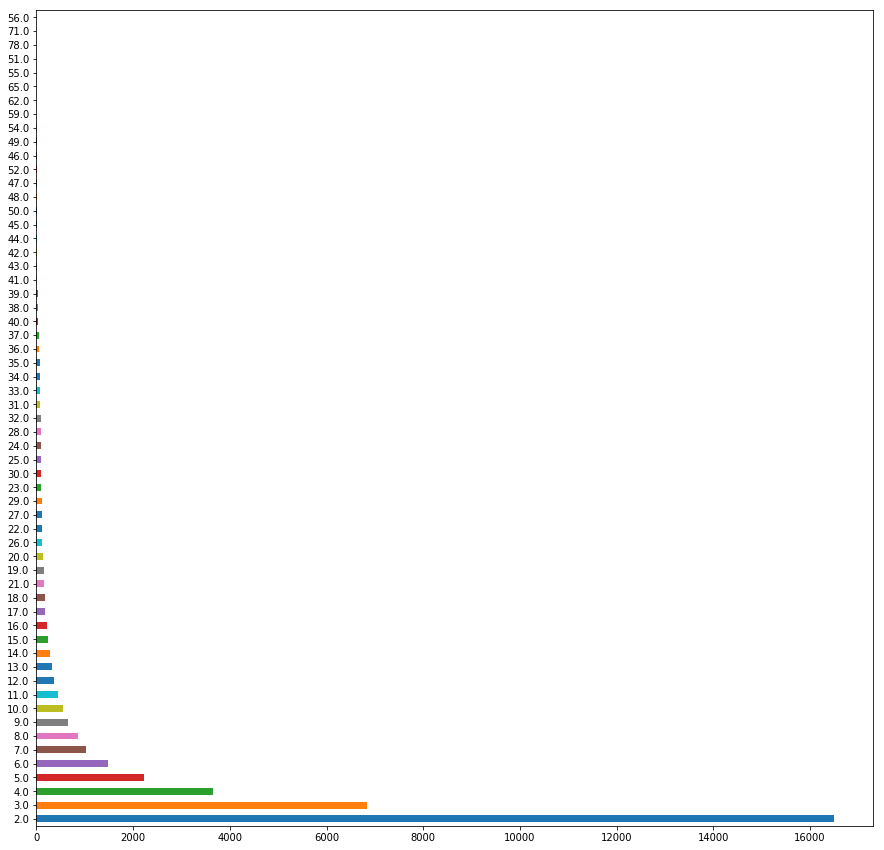

In [53]:
int_movie_counter = {}

int_movie_counter['tconst'] = df_country.keys()
count_list = []

for movie in df_country.keys():
    count_list.append(df_country[movie]['country_count'])    
    
int_movie_counter['country_count'] = count_list
      
df_country_counts = pd.DataFrame.from_dict(int_movie_counter)
print(df_country.info())
df_country_counts['country_count'].value_counts().sort_values(ascending=False).plot.barh(figsize=(15,15));

## Cleaning and Counting - Domestic and International Profits

In [62]:
print(df_finance.info())
df_finance.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.1+ KB
None


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [64]:
# def column_string_cleaner (df, column_name, dtype, to_replace=None, new_value=None):
    
#     '''This function cleans and converts any column, or list of columns, within 
#     a given DataFrame. This function takes in a DataFrame object, a column name 
#     (or list of column names), the desired output dtype, to_replace values, 
#     as well as new_values.'''
    
#     if type(to_replace) == list:
#         for i in range(len(to_replace)):
#             df[column_name].str.replace(to_replace[i], new_value[i])
#             print('Line #1')
#         df[column_name].astype(dtype)
# #     elif type(to_replace) == list and type(new_value) != list:
# #         for i in range(len(to_replace)):
# #             df[column_name].str.replace(to_replace[i], new_value)
# #             print('Line # 2')
# #         df[column_name].astype(dtype)
#     else:
#         df[column_name].str.replace(to_replace, new_value).astype(dtype)
#         print('Line #3')
#     return df

# column_string_cleaner(df2, 'worldwide_gross', float, to_replace=['$',','], new_value=['',''])


df_finance['worldwide_gross'] = df_finance['worldwide_gross'].str.replace('$', '').str.replace(',','').astype(float)
df_finance['production_budget'] = df_finance['production_budget'].str.replace('$', '').str.replace(',','').astype(float)
df_finance['domestic_gross'] = df_finance['domestic_gross'].str.replace('$', '').str.replace(',','').astype(float)


df_finance

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,300000000.0,309420425.0,9.634204e+08
8,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,6.559452e+08
9,10,"Nov 6, 2015",Spectre,300000000.0,200074175.0,8.796209e+08


<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked


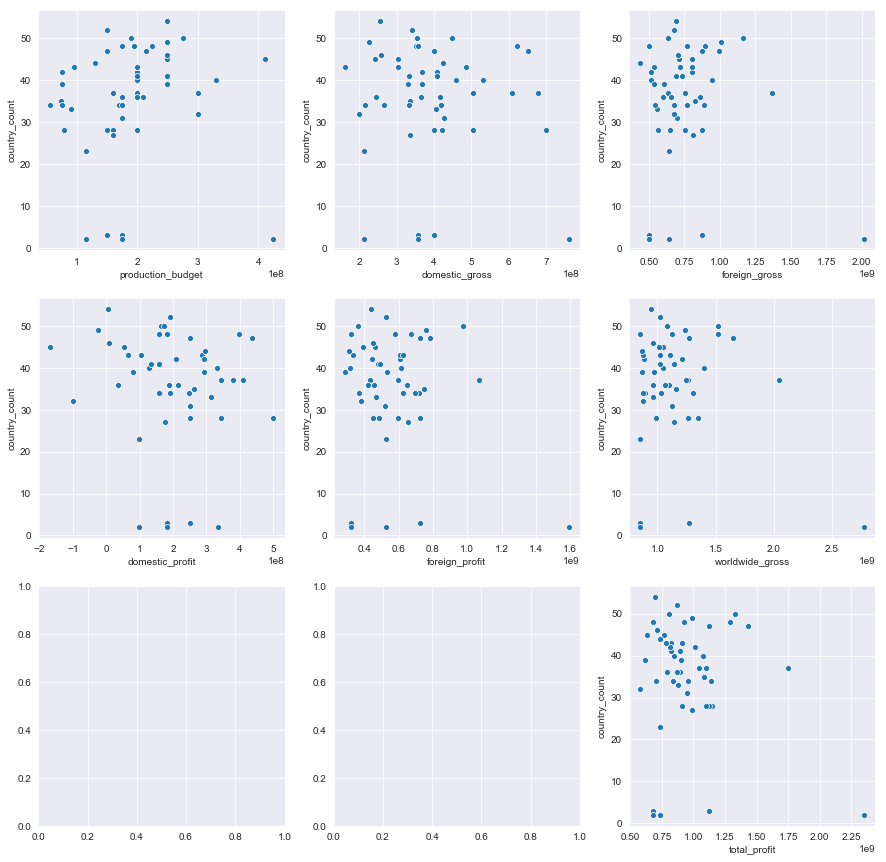

In [219]:

df2 = df2.sort_values('worldwide_gross', ascending=False).iloc[:200]

df2['foreign_gross'] = df2['worldwide_gross'] - df2['domestic_gross']
df2['domestic_profit'] = df2['domestic_gross'] - df2['production_budget']
df2['foreign_profit'] = df2['foreign_gross'] - df2['production_budget']
df2['total_profit'] = df2['worldwide_gross'] - df2['production_budget']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

y = df2['country_count']
x = [df2['production_budget'], df2['domestic_gross'], df2['foreign_gross'],
     df2['worldwide_gross'], df2['domestic_profit'], df2['foreign_profit'],
     df2['total_profit']]
z = ['production_budget', 'domestic_gross', 'foreign_gross',
     'worldwide_gross', 'domestic_profit', 'foreign_profit',
     'total_profit']

for n in range(1,8):
    row = (n-1)//3
    col = n%4-1
    ax = axes[row][col]
    x1 = x[n-1]
    print(type(x))
    print(type(y))
    sns.set_style('darkgrid')
    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    sns.scatterplot(x1, y, ax=ax)
    print('worked')

# df2
# df2.plot.scatter(x=['total_profit'], y=['country_count'], figsize=(15,15), ax =axes);

In [111]:
# country_counts = country_counts.merge(movie_titles, on='tconst')
country_counts['country_count'].replace(5,1)
# .join(movie_money, how='inner', on='primary_title', rsuffix='*')
# pd.concat([country_counts, movie_money], axis=1, join='inner', ignore_index=True)

0        59.0
1        54.0
2        54.0
3        52.0
4        52.0
5        52.0
6        50.0
7        50.0
8        50.0
9        50.0
10       50.0
11       50.0
12       49.0
13       49.0
14       48.0
15       48.0
16       48.0
17       48.0
18       48.0
19       48.0
20       47.0
21       47.0
22       47.0
23       47.0
24       47.0
25       47.0
26       46.0
27       46.0
28       46.0
29       45.0
30       45.0
31       45.0
32       45.0
33       45.0
34       45.0
35       44.0
36       44.0
37       44.0
38       44.0
39       44.0
40       44.0
41       44.0
42       43.0
43       43.0
44       43.0
45       43.0
46       43.0
47       43.0
48       43.0
49       43.0
50       43.0
51       43.0
52       43.0
53       42.0
54       42.0
55       42.0
56       42.0
57       42.0
58       42.0
59       42.0
60       42.0
61       42.0
62       42.0
63       41.0
64       41.0
65       41.0
66       41.0
67       41.0
68       41.0
69       41.0
70       41.0
71    